In [1]:
%matplotlib inline

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import pathlib

from PIL import Image
import scipy as sp
from scipy.ndimage import label
from skimage.measure import regionprops
from matplotlib import patches

import json
import os
from PIL import Image

import wandb
from wandb.keras import WandbCallback

config =  ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = InteractiveSession(config=config)

## 데이터 전처리

In [2]:
batch_size = 64
IMG_SIZE = 224

title = 'VOC2012_7_back'

train_dir = f'{title}_dataset/bilateral_filter_train'
val_dir = f'{title}_dataset/val'
test_dir = f'{title}_dataset/test'

In [3]:
np.random.seed(42)

train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range =20,
    width_shift_range = 0.2,
    height_shift_range=0.2,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical'
)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    batch_size=batch_size,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical'
)


test_ds = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical'
)

Found 1376 images belonging to 8 classes.
Found 456 images belonging to 8 classes.
Found 472 images belonging to 8 classes.


In [4]:
train_ds.class_indices

{'0background': 0,
 'aeroplane': 1,
 'bird': 2,
 'car': 3,
 'cat': 4,
 'dog': 5,
 'person': 6,
 'train': 7}

In [5]:
vgg_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                        include_top = False,
                                        input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [6]:
# model = resnet_model.output
# model = tf.keras.layers.Conv2D(filters=2048, kernel_size=(3, 3), padding='same', activation='relu')(model)
# model = tf.keras.layers.GlobalAveragePooling2D()(model)
# prediction = tf.keras.layers.Dense(len(train_ds.class_indices), activation='softmax')(model)
# model = Model(inputs=resnet_model.input, outputs=prediction)
# model.summary()

In [7]:
model = tf.keras.Sequential()

for layer in vgg_model.layers[:-1]: # just exclude last layer from copying
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(len(train_ds.class_indices), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [8]:
wandb.init(project="KICS_winter", entity="yhkim", name=f"VGG16_{title}_0103_bilateral_filter",
           config = {
              "epochs": 100,
              "batch_size": 64,
              "lr" : 0.0001
            })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yhkim (use `wandb login --relogin` to force relogin)
C:\Users\KYH\.conda\envs\tensor\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:
config = wandb.config

In [10]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=config.lr), 
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=["accuracy"])


history = model.fit(train_ds,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    validation_data=val_ds,
                    callbacks=[WandbCallback()]
                   )

wandb.finish()

Epoch 1/100
22/22 [==============================] - 17s 760ms/step - loss: 1.9050 - accuracy: 0.2871 - val_loss: 1.5667 - val_accuracy: 0.4912
Epoch 2/100
22/22 [==============================] - 12s 559ms/step - loss: 1.5420 - accuracy: 0.4797 - val_loss: 1.2380 - val_accuracy: 0.6009
Epoch 3/100
22/22 [==============================] - 12s 559ms/step - loss: 1.3476 - accuracy: 0.5392 - val_loss: 1.0683 - val_accuracy: 0.6360
Epoch 4/100
22/22 [==============================] - 12s 564ms/step - loss: 1.2251 - accuracy: 0.5807 - val_loss: 0.9807 - val_accuracy: 0.6689
Epoch 5/100
22/22 [==============================] - 12s 558ms/step - loss: 1.1554 - accuracy: 0.6112 - val_loss: 0.9274 - val_accuracy: 0.6908
Epoch 6/100
22/22 [==============================] - 12s 552ms/step - loss: 1.0958 - accuracy: 0.6308 - val_loss: 0.9345 - val_accuracy: 0.6908
Epoch 7/100
22/22 [==============================] - 12s 550ms/step - loss: 1.0608 - accuracy: 0.6453 - val_loss: 0.9640 - val_accuracy:

22/22 [==============================] - 23s 1s/step - loss: 0.5985 - accuracy: 0.8067 - val_loss: 0.8991 - val_accuracy: 0.6732
Epoch 59/100
22/22 [==============================] - 24s 1s/step - loss: 0.6010 - accuracy: 0.7987 - val_loss: 0.8608 - val_accuracy: 0.6974
Epoch 60/100
22/22 [==============================] - 23s 1s/step - loss: 0.5826 - accuracy: 0.8001 - val_loss: 0.9240 - val_accuracy: 0.6798
Epoch 61/100
22/22 [==============================] - 24s 1s/step - loss: 0.5873 - accuracy: 0.8023 - val_loss: 0.8785 - val_accuracy: 0.7039
Epoch 62/100
22/22 [==============================] - 23s 1s/step - loss: 0.5848 - accuracy: 0.7987 - val_loss: 0.9622 - val_accuracy: 0.6667
Epoch 63/100
22/22 [==============================] - 23s 1s/step - loss: 0.5966 - accuracy: 0.7943 - val_loss: 0.8630 - val_accuracy: 0.6952
Epoch 64/100
22/22 [==============================] - 23s 1s/step - loss: 0.5820 - accuracy: 0.8176 - val_loss: 0.8840 - val_accuracy: 0.6886
Epoch 65/100
22/22 

accuracy,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█████▇█████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▇▇█▇████▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇██▇▇▇▇█▇██
val_loss,█▄▂▂▂▂▁▁▁▁▂▂▂▂▁▂▁▂▂▁▂▂▂▂▂▂▂▁▁▂▂▂▂▃▂▂▂▃▂▂
accuracy,0.8452
best_epoch,20
best_val_loss,0.76915
epoch,99
loss,0.47618
val_accuracy,0.70833


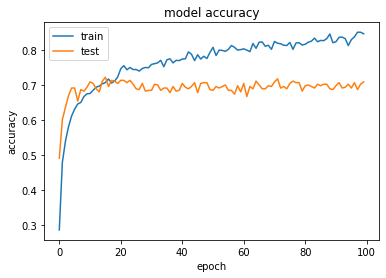

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

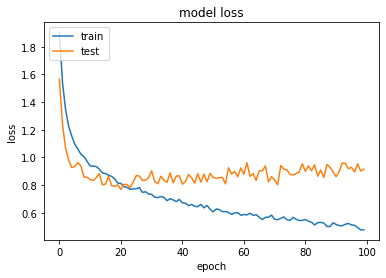

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
model.save(f'VGG16_{title}_0103_bilateral_filter')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: VGG16_VOC2012_7_back_0103_bilateral_filter\assets


In [14]:
model.evaluate(test_ds)

8/8 [==============================] - 9s 1s/step - loss: 0.9855 - accuracy: 0.6864


[0.9855309128761292, 0.6864407062530518]

In [15]:
json.dump(history.history, open(f'VGG16_{title}_0103_bilateral_filter.json', 'w'))